**DHS in-country cross-validated model results.**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-Saved-Data" data-toc-modified-id="Load-Saved-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Saved Data</a></span><ul class="toc-item"><li><span><a href="#Load-labels,-locs,-and-years" data-toc-modified-id="Load-labels,-locs,-and-years-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load <code>labels</code>, <code>locs</code>, and <code>years</code></a></span></li><li><span><a href="#Load-loc_dict" data-toc-modified-id="Load-loc_dict-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load <code>loc_dict</code></a></span></li><li><span><a href="#Get-urban-v.-rural-indices" data-toc-modified-id="Get-urban-v.-rural-indices-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get urban v. rural indices</a></span></li><li><span><a href="#country_indices-and-country_labels" data-toc-modified-id="country_indices-and-country_labels-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span><code>country_indices</code> and <code>country_labels</code></a></span></li></ul></li><li><span><a href="#Load-saved-preds" data-toc-modified-id="Load-saved-preds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load saved preds</a></span><ul class="toc-item"><li><span><a href="#Create-CSV-of-all-preds" data-toc-modified-id="Create-CSV-of-all-preds-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create CSV of all preds</a></span></li></ul></li><li><span><a href="#Overall-MSE,-$R^2$,-$r^2$,-rank-corr" data-toc-modified-id="Overall-MSE,-$R^2$,-$r^2$,-rank-corr-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Overall MSE, $R^2$, $r^2$, rank-corr</a></span><ul class="toc-item"><li><span><a href="#Individual-model-results" data-toc-modified-id="Individual-model-results-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Individual model results</a></span></li><li><span><a href="#Model-Similarity-Heatmaps" data-toc-modified-id="Model-Similarity-Heatmaps-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Model Similarity Heatmaps</a></span></li><li><span><a href="#Cumulative-analysis" data-toc-modified-id="Cumulative-analysis-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Cumulative analysis</a></span></li></ul></li><li><span><a href="#Break-down-by-country,-urban/rural" data-toc-modified-id="Break-down-by-country,-urban/rural-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Break-down by country, urban/rural</a></span></li><li><span><a href="#$r^2$-over-all-countries" data-toc-modified-id="$r^2$-over-all-countries-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>$r^2$ over all countries</a></span></li><li><span><a href="#Break-down-by-country-year,-urban/rural" data-toc-modified-id="Break-down-by-country-year,-urban/rural-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Break-down by country-year, urban/rural</a></span></li><li><span><a href="#Urban/rural" data-toc-modified-id="Urban/rural-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Urban/rural</a></span><ul class="toc-item"><li><span><a href="#By-Country" data-toc-modified-id="By-Country-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>By Country</a></span></li></ul></li><li><span><a href="#Model-performance-as-function-of-NL" data-toc-modified-id="Model-performance-as-function-of-NL-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model performance as function of NL</a></span><ul class="toc-item"><li><span><a href="#When-NL-=-0" data-toc-modified-id="When-NL-=-0-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>When NL = 0</a></span></li><li><span><a href="#Predictions-vs.-NL-mean" data-toc-modified-id="Predictions-vs.-NL-mean-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Predictions vs. NL mean</a></span></li></ul></li></ul></div>

# Imports and Constants

Installing Libraries

In [2]:
!pip install matplotlib
!pip install seaborn
!pip install pandas==0.25.3

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached seaborn-0.12.1-py3-none-any.whl (288 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached pandas-0.25.3-cp37-cp37m-manylinux1_x86_64.whl (10.4 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.0
    Uninstalling pandas-1.1.0:
      Successfully uninstalled pandas-1.1.0
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from collections import defaultdict
import itertools
import pickle
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from batchers import dataset_constants
from utils.analysis import (
    calc_score,
    chunk_vs_score,
    evaluate_df,
    plot_chunk_vs_score,
    plot_label_vs_score,
    plot_percdata_vs_score,
    sorted_scores)
from utils.general import colordisplay, load_npz
from utils.plot import scatter_preds, symmetric_heatmap

In [3]:
print(pd.__version__)

0.25.3


All the models Already trained with the directories to its basefiles

In [4]:
label = "longevity"
LOGS_ROOT_DIR = f'/root/logs/{label}/'
DATASET_NAME = 'DHS_OOC_A'
base_path = f"/root/logs/{label}"
MODEL_NAME_TO_DIR = {
    # KNN
           'KNN NL mean scalar': base_path + '/dhs_knn/incountry_nlmean_scalar',
           'KNN NL center scalar': base_path + '/dhs_knn/incountry_nlcenter_scalar',
           'KNN NL hist': base_path +  '/dhs_knn/incountry_nl_hist',
    
    # Ridge
           'Ridge NL mean scalar': base_path + '/dhs_ridge/incountry_nlmean_scalar',
           'Ridge NL center scalar': base_path + '/dhs_ridge/incountry_nlcenter_scalar',
           'Ridge RGB hist':  base_path + '/dhs_ridge/incountry_rgb_hist',
           'Ridge MS hist': base_path + '/dhs_ridge/incountry_ms_hist',
           'Ridge NL hist': base_path + '/dhs_ridge/incountry_nl_hist',
           'Ridge RGB+NL hist': base_path + '/dhs_ridge/incountry_rgbnl_hist',
           'Ridge MS+NL hist': base_path + '/dhs_ridge/incountry_msnl_hist',

     #Resnet
        'Resnet-18 MS': base_path + '/resnet_ms',
        'Resnet-18 NL': base_path + '/resnet_nl',
        'Resnet-18 MS+NL concat': base_path + '/resnet_msnl_concat',
       #'Resnet-18 NL': '/hdd/home/abenabbes/final_ex/nouveau/dhsincountry/resnet_nl',
       #'Resnet-18 RGB': '/hdd/home/abenabbes/final_ex/dhsincountry/resnet_rgb',
       #'Resnet-18 RGBNL': '/hdd/home/abenabbes/final_ex/dhsincountry/resnet_rgbnl_concat',
    

    # Transfer
      #'Resnet-18 RGB Transfer': 'dhs_resnet/incountry_rgb_transfer',
      #'Resnet-18 MS Transfer': 'dhs_resnet/incountry_ms_transfer',
}

MODEL_NAMES = sorted(MODEL_NAME_TO_DIR.keys())

# Load Saved Data

## Load `labels`, `locs`, and `years`

In [5]:
countries=["brazil"]

In [6]:
#npz = load_npz('/hdd/home/abenabbes/final_ex/dhs_image_hists.npz')
npz = load_npz(f'/root/Datasets/SelectedClusters/dhs_co_{label}.npz')

labels = npz['labels']
locs = npz['locs']
years = npz['years']
nls_center = npz['nls_center']
nls_mean = npz['nls_mean']

num_examples = len(labels)
assert np.all(np.asarray([len(labels), len(locs), len(years), len(nls_center), len(nls_mean)]) == num_examples)
print(labels)

image_hists: dtype=int64, shape=(20438, 8, 102)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
nls_center: dtype=float32, shape=(20438,)
nls_mean: dtype=float32, shape=(20438,)
[0.85707    0.6969067  0.5205223  ... 0.7833033  0.68333334 0.71666664]


## Load `loc_dict`

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': False,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    }, ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

In [7]:
loc_dict_path = f'/root/Datasets/SelectedClusters/loc_dict_brazil_2010_{label}.pkl'
with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)

## Get urban v. rural indices

In [8]:
def get_urban_rural_indices(locs, loc_dict):
    '''
    Args
    - locs: np.array, shape [N, 2]
    - loc_dict: dict, (lat, lon) => dict

    Returns
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    urban_indices = []
    rural_indices = []

    for i, loc in enumerate(locs):
        loc = tuple(loc)
        if loc_dict[loc]['urban'] == 'RURAL':
            rural_indices.append(i)
        else:
            urban_indices.append(i)
    urban_indices = np.asarray(urban_indices)
    rural_indices = np.asarray(rural_indices)
    print(f'num urban: {len(urban_indices)}\t num rural: {len(rural_indices)}')
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs, loc_dict)

num urban: 438	 num rural: 20000


## `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```python
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }
```

`country_labels` is a `np.array` that shows which country each example belongs to
```python
np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`

In [9]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(num_examples, dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    country = loc_dict[tuple(loc)]['country']
    country_indices[country].append(i)

for i, country in enumerate(countries):
    country_indices[country] = np.asarray(country_indices[country])
    print(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

country_indices['overall'] = np.arange(num_examples)

[    0     1     2 ... 20435 20436 20437]


# Load saved preds

In [10]:
preds = {}

for model_name, model_dir in MODEL_NAME_TO_DIR.items():
    print(model_name)
    npz_path = os.path.join(LOGS_ROOT_DIR, model_dir, 'test_preds.npz')
    preds[model_name] = load_npz(npz_path)['test_preds']

KNN NL mean scalar
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
KNN NL center scalar
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
KNN NL hist
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
Ridge NL mean scalar
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
Ridge NL center scalar
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
Ridge RGB hist
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
Ridge MS hist
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
Ridge NL hist
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
Ridge RGB+NL hist
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
Ridge MS+NL hist
labels: dtype=float32, shape=(20438,)
test_preds: dtype=float32, shape=(20438,)
Resnet-18 MS
labels: dtype

## Create CSV of all preds

In [11]:
preds_df = pd.DataFrame(
    columns=['lat', 'lon', 'country', 'year', 'urban', 'label'] + MODEL_NAMES)
preds_df['lat'] = locs[:, 0]
preds_df['lon'] = locs[:, 1]
preds_df['label'] = labels
preds_df['year'] = years
preds_df['country'] = np.asarray(countries)[country_labels]
preds_df.loc[:, 'urban'] = False
preds_df.loc[urban_indices, 'urban'] = True

for model_name in MODEL_NAMES:
    print(model_name)
    preds_df[model_name] = preds[model_name]

preds_df.to_csv(LOGS_ROOT_DIR + 'dhs_incountry_predsnew.csv', index=False)


KNN NL center scalar
KNN NL hist
KNN NL mean scalar
Resnet-18 MS
Resnet-18 MS+NL concat
Resnet-18 NL
Ridge MS hist
Ridge MS+NL hist
Ridge NL center scalar
Ridge NL hist
Ridge NL mean scalar
Ridge RGB hist
Ridge RGB+NL hist


In [12]:
with pd.option_context('display.max_rows', 20):
    display(preds_df)

preds_df.to_csv(LOGS_ROOT_DIR + 'alldata.csv')


,lat,lon,country,year,urban,label,KNN NL center scalar,KNN NL hist,KNN NL mean scalar,Resnet-18 MS,Resnet-18 MS+NL concat,Resnet-18 NL,Ridge MS hist,Ridge MS+NL hist,Ridge NL center scalar,Ridge NL hist,Ridge NL mean scalar,Ridge RGB hist,Ridge RGB+NL hist
0,-22.890057,-47.071133,brazil,2010,True,0.857070,0.741969,0.732360,0.734347,0.716210,0.719448,0.753525,0.685868,0.721807,0.829417,0.745595,0.818610,0.700452,0.724865
1,-7.464113,-45.133427,brazil,2010,False,0.696907,0.703589,0.689813,0.689813,0.731705,0.731902,0.699778,0.678488,0.677886,0.700370,0.694563,0.700388,0.685953,0.684480
2,-20.237682,-48.617920,brazil,2010,False,0.520522,0.748224,0.743536,0.749942,0.692406,0.692791,0.700241,0.725845,0.739138,0.703056,0.729974,0.702255,0.730030,0.747346
3,-16.556767,-49.227837,brazil,2010,False,0.778582,0.747333,0.733093,0.736051,0.752311,0.754276,0.752691,0.724961,0.729326,0.704031,0.726595,0.705816,0.706887,0.713420
4,-14.360595,-48.481579,brazil,2010,False,0.850000,0.707264,0.743187,0.758076,0.731685,0.731847,0.698312,0.720556,0.722322,0.701655,0.708525,0.702370,0.721395,0.720843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20433,-19.891603,-54.431175,brazil,2010,False,0.794938,0.703589,0.753847,0.751219,0.761294,0.763720,0.710688,0.714867,0.716392,0.700370,0.705534,0.700606,0.719272,0.722409
20434,-12.263503,-57.969074,brazil,2010,True,0.766667,0.703589,0.689813,0.689813,0.616023,0.616333,0.699210,0.448564,0.448657,0.700370,0.694563,0.700388,0.537452,0.538560
20435,-8.684114,-46.136360,brazil,2010,False,0.783303,0.701174,0.686455,0.693708,0.603612,0.603614,0.697163,0.674391,0.671278,0.700687,0.694732,0.700695,0.722907,0.715773
20436,-17.457121,-56.392990,brazil,2010,False,0.683333,0.701174,0.686455,0.693708,0.726138,0.726361,0.697163,0.718609,0.715936,0.700687,0.694732,0.700695,0.732076,0.728991


# Overall MSE, $R^2$, $r^2$, rank-corr

## Individual model results

In [13]:
overall_df = evaluate_df(preds_df, cols=MODEL_NAMES)
overall_df.sort_values(by='r2', ascending=False, inplace=True)
display(overall_df)
overall_df.to_csv(LOGS_ROOT_DIR + 'performance.csv')

,r2,R2,mse,rank
Resnet-18 MS+NL concat,0.159371,0.158791,0.023314,0.370183
Resnet-18 MS,0.158332,0.157707,0.023344,0.367862
Ridge MS+NL hist,0.111511,0.111202,0.024633,0.303311
Ridge MS hist,0.110002,0.109761,0.024673,0.296517
Ridge RGB+NL hist,0.078599,0.078583,0.025537,0.247138
Ridge RGB hist,0.075375,0.075371,0.025626,0.232775
KNN NL mean scalar,0.019927,0.019889,0.027164,0.115323
KNN NL hist,0.019915,0.019806,0.027166,0.111359
Ridge NL hist,0.011072,0.011059,0.027409,0.108804
Resnet-18 NL,0.006847,0.006824,0.027526,0.065991


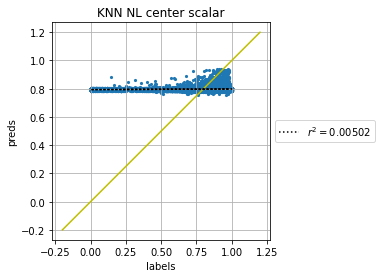

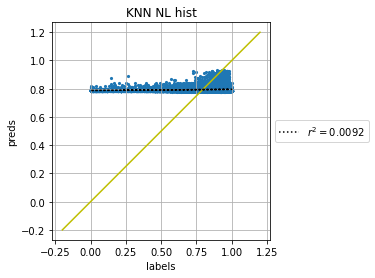

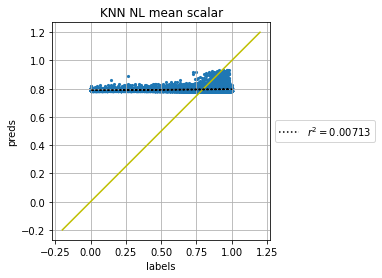

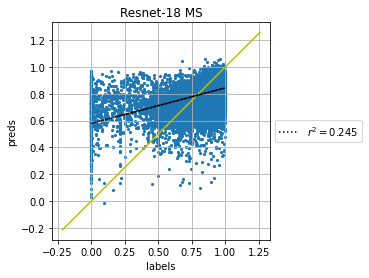

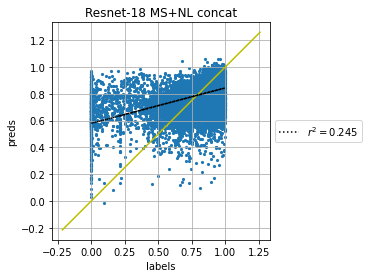

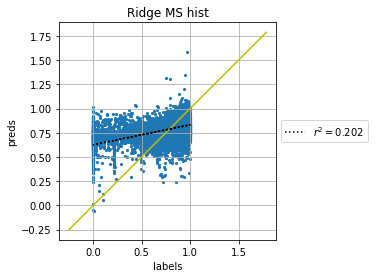

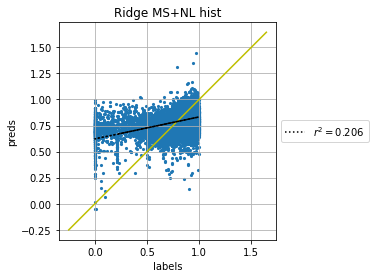

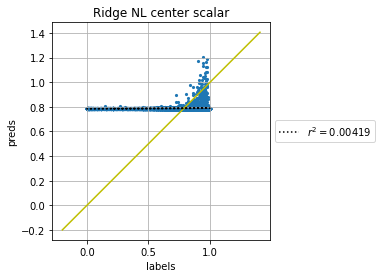

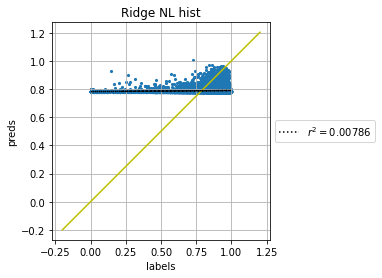

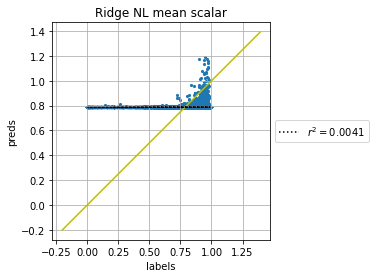

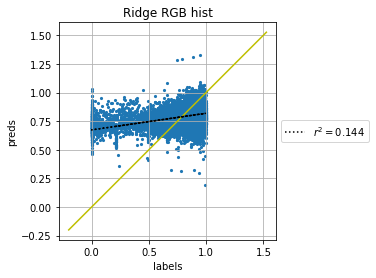

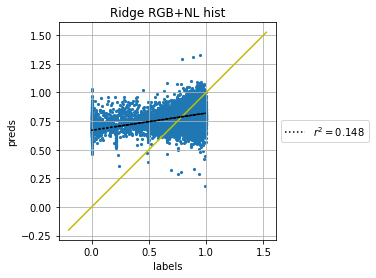

In [14]:
for model_name in MODEL_NAMES:
    model_preds = preds[model_name]
    scatter_preds(
        labels=labels,
        preds=model_preds,
        title=model_name,
        figsize=(4, 4))

# Stopped running the code at this point

## Model Similarity Heatmaps

In [ ]:
model_names_by_mse = overall_df.sort_values(by='mse').index
print(model_names_by_mse)
num_models = len(preds)

r2_mat = np.eye(num_models, dtype=np.float64)
rank_mat = np.eye(num_models, dtype=np.float64)

for i, j in itertools.combinations(range(num_models), r=2):
    model_name1 = model_names_by_mse[i]
    model_name2 = model_names_by_mse[j]

    m1_preds = preds[model_name1]
    m2_preds = preds[model_name2]

    r2_mat[i, j] = calc_score(m1_preds, m2_preds, metric='r2')
    rank_mat[i, j] = calc_score(m1_preds, m2_preds, metric='rank')
    r2_mat[j, i] = r2_mat[i, j]
    rank_mat[j, i] = rank_mat[i, j]

In [ ]:
symmetric_heatmap(r2_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test r^2')
symmetric_heatmap(rank_mat, labels=model_names_by_mse, format_spec='{:.2f}', title='test rank corr.')

## Cumulative analysis

In [ ]:
ridge_model_indices, ridge_model_names = [], []
resnet_model_indices, resnet_model_names = [], []

for i, model_name in enumerate(model_names_by_mse):
    if 'Resnet' not in model_name:
        ridge_model_indices.append(i)
        ridge_model_names.append(model_name)
    elif 'Resnet' in model_name:
        resnet_model_indices.append(i)
        resnet_model_names.append(model_name)

In [ ]:
chunk_r2s = np.zeros([len(model_names_by_mse), 5])
for i, model_name in enumerate(model_names_by_mse):
    chunk_r2s[i, :] = chunk_vs_score(preds=preds[model_name], labels=labels, nchunks=5, metric='r2')

plot_chunk_vs_score(scores=chunk_r2s[ridge_model_indices], figsize=(6, 3),
                    legends=ridge_model_names, metric='r2')

plot_chunk_vs_score(scores=chunk_r2s[resnet_model_indices], figsize=(6, 3),
                    legends=resnet_model_names, metric='r2')

In [ ]:
dmsp_mask = years < 2012
viirs_mask = ~dmsp_mask

for name, mask in [('DMSP', dmsp_mask), ('VIIRS', viirs_mask)]:
    chunk_r2s = np.zeros([len(model_names_by_mse), 5])
    chunk_R2s = np.zeros([len(model_names_by_mse), 5])
    for i, model_name in enumerate(model_names_by_mse):
        chunk_r2s[i, :] = chunk_vs_score(labels=labels[mask], preds=preds[model_name][mask], nchunks=5,
                                         metric='r2', chunk_value=nls_mean[mask])
        chunk_R2s[i, :] = chunk_vs_score(labels=labels[mask], preds=preds[model_name][mask], nchunks=5,
                                         metric='R2', chunk_value=nls_mean[mask])

    plot_chunk_vs_score(scores=chunk_r2s, legends=overall_df.index, metric='r2',
                        figsize=(10, 3), cmap='tab20', xlabel=f'chunk of increasing NL mean ({name})')
    plot_chunk_vs_score(scores=chunk_R2s, legends=overall_df.index, metric='R2',
                        figsize=(10, 3), cmap='tab20', xlabel=f'chunk of increasing NL mean ({name})')

In [ ]:
cumulative_r2s = np.zeros([len(model_names_by_mse), num_examples])

for i, model_name in enumerate(model_names_by_mse):
    r2s, labels_sorted = sorted_scores(
        preds=preds[model_name], labels=labels, metric='R2', sort='increasing')
    cumulative_r2s[i, :] = r2s

In [ ]:
cumulative_r2_df = pd.DataFrame(
    data=cumulative_r2s.T,
    index=pd.Index(np.sort(labels), name='wealthpooled'),
    columns=model_names_by_mse)
with pd.option_context('display.max_rows', 20):
    display(cumulative_r2_df)

cumulative_r2_df.to_csv('dhs_incountry_cumulative_r2.csv', index=True)

In [ ]:
plot_percdata_vs_score(
    scores_list=cumulative_r2s[ridge_model_indices],
    legends=ridge_model_names,
    metric='r2',
    sort='increasing')

plot_percdata_vs_score(
    scores_list=cumulative_r2s[resnet_model_indices],
    legends=resnet_model_names,
    metric='r2',
    sort='increasing')

plot_label_vs_score(
    scores_list=cumulative_r2s[ridge_model_indices],
    labels_list=[np.sort(labels)] * len(ridge_model_indices),
    legends=ridge_model_names,
    metric='r2',
    sort='increasing')

plot_label_vs_score(
    scores_list=cumulative_r2s[resnet_model_indices],
    labels_list=[np.sort(labels)] * len(resnet_model_indices),
    legends=resnet_model_names,
    metric='r2',
    sort='increasing')

# Break-down by country, urban/rural

In [ ]:
country_df = (
    preds_df
    .groupby('country')
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))

country_urban_df = (
    preds_df
    .groupby(['country', 'urban'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))







with pd.option_context('display.max_rows', 4, 'display.precision', 3):
    display(country_df)
    display(country_urban_df)
    
country_df.to_csv('/hdd/home/abenabbes/a.csv')

country_urban_df.to_csv('/hdd/home/abenabbes/b.csv')


# $r^2$ over all countries

In [ ]:
# get mean and median r^2 across countries
country_r2_df = country_df['r2'].unstack('model')
colordisplay(country_r2_df.describe().T)

print('urban:')
colordisplay(country_urban_df['r2'].unstack('model').loc[(slice(None), True), :].describe().T)

print('rural:')
colordisplay(country_urban_df['r2'].unstack('model').loc[(slice(None), False), :].describe().T)

In [ ]:
def weighted_r2(x):
    '''
    Args
    - x: pd.Series, index is (country, metric), value is score

    Returns:
    - y: float
    '''
    y = np.sum([
        x[country] * len(country_indices[country]) / len(labels)
        for country in x.index.get_level_values(0)
    ])
    return y

median_r2s = country_r2_df.median(axis=0).rename('median r2')
mean_r2s = country_r2_df.mean(axis=0).rename('mean r2')
weighted_r2s = country_r2_df.apply(weighted_r2, axis=0).rename('weighted r2')
overall_r2s = overall_df.loc[MODEL_NAMES, 'r2'].rename('overall r2')

agg_r2s = pd.concat([weighted_r2s, median_r2s, mean_r2s, overall_r2s], axis=1)
agg_r2s.sort_values(by='weighted r2', ascending=False, inplace=True)
colordisplay(agg_r2s)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
agg_r2s.T.plot(kind='bar', ax=ax, width=0.9, colormap='tab20')
plt.setp(ax.get_xticklabels(), rotation=0, ha='center',
         rotation_mode='anchor')
ax.set_ylabel('r^2')
ax.set_title('Incountry r^2 on test countries')
ax.grid(True, axis='y')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

In [ ]:
def plot_country_performance(df, model_names, title, xlabel):
    '''
    Args
    - df: pd.DataFrame, df.loc[country, model_name] gives model performance on a particular country
    - model_names: list of str
    - title: str
    - xlabel: str
    '''
    CMAP_FN = plt.cm.get_cmap('tab20')
    COUNTRY_YEAR_COLORS = [CMAP_FN.colors[i % 20] for i in range(len(countries))]

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    for i, country in enumerate(countries):
        r2s = df.loc[country, model_names]
        size = len(country_indices[country]) / len(labels) * 1000
        ax.scatter(x=r2s, y=model_names, s=size, c=[COUNTRY_YEAR_COLORS[i]], label=country)

    ax.invert_yaxis()  # invert direction to put best-performing models at the top
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()

plot_country_performance(
    df=country_r2_df,
    model_names=list(agg_r2s.index),
    title='Incountry Test Performance',
    xlabel='test r^2')

# Break-down by country-year, urban/rural

In [ ]:
countryyear_df = (
    preds_df
    .groupby(['country', 'year'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))
countryyear_urban_df = (
    preds_df
    .groupby(['country', 'year', 'urban'])
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model'))

with pd.option_context('display.max_rows', 4, 'display.precision', 3):
    display(countryyear_df)
    display(countryyear_urban_df)

In [ ]:
# get mean and median r^2 across country_years
countryyear_r2_df = countryyear_df['r2'].unstack('model')
colordisplay(countryyear_r2_df.describe().T)

print('urban:')
colordisplay(countryyear_urban_df['r2'].unstack('model').loc[(slice(None), slice(None), True), :].describe().T)

print('rural:')
colordisplay(countryyear_urban_df['r2'].unstack('model').loc[(slice(None), slice(None), False), :].describe().T)

# Urban/rural

In [ ]:
urban_rural_df = (
    preds_df
    .groupby('urban')
    .apply(evaluate_df, cols=MODEL_NAMES, index_name='model')
    .unstack('urban'))

with pd.option_context('display.max_rows', 20, 'display.precision', 3):
    display(urban_rural_df)

In [ ]:
ax = urban_rural_df.loc[:, ('r2', slice(None))].plot(
    kind='bar', figsize=[10, 5])
ax.set_ylabel('test $r^2$ on urban/rural')
ax.set_ylim(bottom=0, top=0.7)
ax.set_title('Model performance ($r^2$) on urban vs. rural')
ax.grid(True, axis='y')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha='right',
         rotation_mode='anchor')
plt.tight_layout()
plt.show()

In [ ]:
ax = urban_rural_df.loc[:, ('R2', slice(None))].plot(
    kind='bar', figsize=[10, 5])
ax.set_ylabel('test $R^2$ on urban/rural')
ax.set_ylim(bottom=0, top=0.8)
ax.set_title('Model performance ($R^2$) on urban vs. rural')
ax.grid(True, axis='y')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha='right',
         rotation_mode='anchor')
plt.tight_layout()
plt.show()

In [ ]:
def plot_urban_rural_predictions(labels, preds, urban_indices, rural_indices):
    '''
    Args
    - labels: np.array, shape [N]
    - preds: dict, model_name => np.array, shape [N]
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    nrows = int(np.ceil(np.sqrt(len(preds))))
    ncols = int(np.ceil(len(preds) / nrows))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            sharey=False, sharex=False, figsize=[ncols*3, nrows*3])
    for model_name, ax in zip(preds, axs.flat):
        ax.scatter(
            x=labels[urban_indices],
            y=preds[model_name][urban_indices],
            s=2, label='urban')
        ax.scatter(
            x=labels[rural_indices],
            y=preds[model_name][rural_indices],
            s=2, label='rural')
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set(xlabel='label', ylabel='pred', title=model_name)
        xy_line = np.array([-2, 3])
        ax.plot(xy_line, xy_line, color='black')
        ax.legend()
    fig.tight_layout()
    plt.show()

plot_urban_rural_predictions(labels, preds, urban_indices, rural_indices)

## By Country

In [ ]:
plot_country_performance(
    df=country_urban_df['r2'].unstack('model').loc[(slice(None), True), :],
    model_names=MODEL_NAMES,
    title='Incountry Test Performance on Urban',
    xlabel='test $r^2$')

plot_country_performance(
    df=country_urban_df['r2'].unstack('model').loc[(slice(None), False), :],
    model_names=MODEL_NAMES,
    title='Incountry Test Performance on Rural',
    xlabel='test $r^2$')

# Model performance as function of NL

## When NL = 0

In [ ]:
from batchers.batcher import MEANS_DICT, STD_DEVS_DICT

dmsp0 = (0.0 - MEANS_DICT[DATASET_NAME]['DMSP']) / STD_DEVS_DICT[DATASET_NAME]['DMSP']
viirs0 = (0.0 - MEANS_DICT[DATASET_NAME]['VIIRS']) / STD_DEVS_DICT[DATASET_NAME]['VIIRS']

print('DMSP 0-value (after normalization):', dmsp0)
print('VIIRS 0-value (after normalization):', viirs0)

dmsp0_indices = (years < 2012) & (nls_mean == dmsp0)
viirs0_indices = (years >= 2012) & (nls_mean == viirs0)
nl0_indices = dmsp0_indices | viirs0_indices

assert np.all(nls_mean[nl0_indices] == dmsp0)
assert np.all(nls_center[nl0_indices] == dmsp0)

In [ ]:
print('# of locs w/ DMSP=0:', np.sum(dmsp0_indices))
print('# of locs w/ VIIRS=0:', np.sum(viirs0_indices))
print('# of locs w/ NL=0:', np.sum(nl0_indices))

Because we train a separate ridge regression model for each left-out test country, we get many different predictions for when NL = 0.

In [ ]:
# np.unique(preds['Resnet-18 NL'][nl0_indices])

In [ ]:
def plot_preds_nl0(model_name, labels, preds, nl0_indices):
    '''
    Args
    - model_name: str
    - labels: np.array, shape [num_examples]
    - preds: np.array, shape [num_examples]
    - nl0_indices: np.array, integer indices into labels/preds
    '''
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])
    ax.scatter(x=labels, y=preds, s=2)
    ax.scatter(x=labels[nl0_indices], y=preds[nl0_indices], c='red', s=2, label='NL = 0')
    ax.set(xlabel='label', ylabel='pred', title=model_name)
    ax.grid(True)
    ax.set_aspect('equal')
    xy_line = np.array([-1.5, 3])
    ax.plot(xy_line, xy_line, color='black')
    ax.legend()
    fig.tight_layout()
    plt.show()

for model_name in MODEL_NAME_TO_DIR:
    plot_preds_nl0(model_name, labels, preds[model_name], nl0_indices)

In [ ]:
nl0_df = evaluate_df(preds_df.loc[nl0_indices, :], cols=MODEL_NAMES)
nl0_df.sort_values('r2', ascending=False, inplace=True)
display(nl0_df.style.format('{:.3f}'))

## Predictions vs. NL mean

In [ ]:
def plot_preds_v_nl(model_name, preds, nl_means):
    '''
    Args
    - model_name: str
    - preds: np.array
    - nl_means: np.array
    '''
    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
    ax.scatter(x=nl_means, y=preds, s=3)
    ax.set_title(model_name)
    ax.set_xlabel('Mean NL of Image (std dev from mean)')
    ax.set_ylabel('Predicted Wealthpooled')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

def plot_residuals_v_nl(model_name, preds, labels, nl_means):
    '''
    Args
    - model_name: str
    - preds: np.array
    - labels: np.array
    - nl_means: np.array
    '''
    residuals = labels - preds
    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
    ax.scatter(x=nl_means, y=residuals, s=3)
    ax.set_title(model_name)
    ax.set_xlabel('Mean NL of Image (std dev from mean)')
    ax.set_ylabel('Residual (label - pred)')
    ax.grid(True)
    fig.tight_layout()
    plt.show()

In [ ]:
for model_name in MODEL_NAME_TO_DIR:
    plot_preds_v_nl(model_name, preds[model_name], nls_mean)

In [ ]:
for model_name in MODEL_NAME_TO_DIR:
    plot_residuals_v_nl(model_name, preds[model_name], labels, nls_mean)